In [ ]:
from google.colab import userdata
import os
from torchvision.io import read_image
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, random_split
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from tqdm import tqdm
import torch

In [ ]:
!pip install tqdm

In [ ]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d nitishabharathi/scene-classification

! unzip "scene-classification.zip"

In [ ]:
IMG_DIR = os.getcwd()+'/train-scene-classification/train'
ANNOTATIONS_FILE = os.getcwd()+'/train-scene-classification/train.csv'

'/content'

In [ ]:
annotations_file = ANNOTATIONS_FILE

image_labels = pd.read_csv(annotations_file)
image_labels

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4
...,...,...
17029,24325.jpg,4
17030,24328.jpg,3
17031,24329.jpg,3
17032,24332.jpg,5


In [ ]:
transforms = v2.Compose([
   v2.RandomResizedCrop(100),
   v2.Resize((150,150)),
   v2.RandomHorizontalFlip(p=0.5)])

In [ ]:
# lets' create a custom dataset class
class ImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform, target_transform = None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx): # idx = row id of item we want
    img_path = os.path.join(img_dir,self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [ ]:
# Preparing your data for training with DataLoaders
from torch.utils.data import DataLoader

data = ImageDataset(annotations_file, img_dir, transform = transforms) # get our dataset
train_size = int(0.8 * len(data)) #set the ratios. We can use len() because it's defined as __len__ in the model. Must convert to int because random_split doesn't like floats. And this could be a float sometimes!!
val_size = len(data) - train_size

train_data, val_data = random_split(data, [train_size, val_size])
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 150, 150])
Labels batch shape: torch.Size([64])


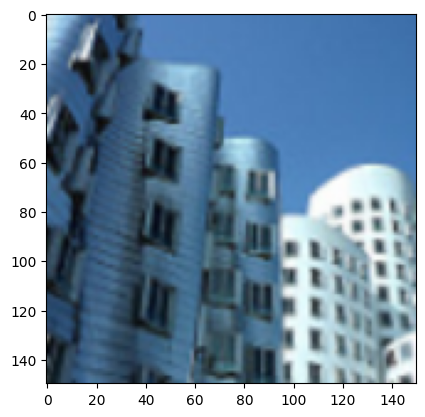

Label: Buildings


In [ ]:
classes = {
  0: 'Buildings',
  1: 'Forests',
  2: 'Mountains',
  3: 'Glacier',
  4: 'Street',
  5: 'Sea'
}
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
img =  np.transpose(img, (1, 2, 0))  # Transpose from (3, 150, 150) to (150, 150, 3)
plt.imshow(img)
plt.show()
print(f"Label: {classes[label.item()]}")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 3, padding = 1) # after a conv layer, image output_size = (input_size - kernel_size + 2 * padding) / stride + 1
    # now image_size = (150 - 3 + 2 * 1) / 1 + 1 = 150
    self.pool = nn.MaxPool2d(2) # image output_size = (input_size - pool_size + 2 * padding) / stride + 1
    # now image_size  = (150 - 2 + 2 *0) / 2 + 1 = 75
    self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 3, padding = 1)
    # now image output_size = (75 - 3 + 2 * 1) / 1 + 1 = 75
    self.pool2 = nn.MaxPool2d(2, stride = 1) # image output_size = (input_size - pool_size + 2 * padding) / stride + 1
    # now image output_size = (75 - 2 + 2 * 0) / 1 + 1 = 74
    self.conv3 = nn.Conv2d(in_channels = 12, out_channels = 3, kernel_size = 2, padding = 1)
    # image output_size = (input_size {74} - kernel_size {2} + 2 * padding {1}) / stride {1} + 1
    # so image output_size = (74 - 2 + 2 * 1) / 1 + 1 = 75
    self.pool3 = nn.MaxPool2d(2, stride = 1) # image output_size = (input_size - pool_size + 2 * padding) / stride + 1
    # image output_size = (75 - 2 + 2 * 0) / 1 + 1 = 74
    self.fc = nn.Linear(74 * 74*3, 6) # imgheight * imgwidth * final out_channels, num_class_labels

  def forward(self, x):
    x = x.float()
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc(x))

    return x
net = Net()

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def validate(model, val_loader, criterion):
       model.eval()
       total_validation_loss = 0
       correct_items = 0
       total_items = 0
       with torch.no_grad():
           for inputs, labels in tqdm(val_loader):
               outputs = model(inputs)
               loss = criterion(outputs, labels)
               total_validation_loss += loss.item()

               _, predicted = torch.max(outputs.data, 1)
               total_items += labels.size(0) # the total amount of labels = the number of rows we have.
               correct_items += (predicted == labels).sum().item()
       accuracy = 100 * (correct_items / total_items)
       return [total_validation_loss, accuracy]

def train(model, train_loader, criterion):
    running_loss = 0.0
    for data, labels in tqdm(train_dataloader):
        inputs = data
        labels = labels

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)

        # Find the Loss
        loss = criterion(outputs, labels)

        # Calculate gradients
        loss.backward()

        # Update Weights
        optimizer.step()

        # print loss
        running_loss += loss.item()

    return running_loss

In [ ]:
num_epochs = 1 # only for demo, so let's just use 1 epoch
for epoch in range(num_epochs):  # loop over the dataset multiple times
    train_loss = train(net, train_dataloader, criterion)
    # Print train statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Training loss: {train_loss/train_size:.4f}')
    # print validation statistics
    val_loss, accuracy = validate(net, valid_dataloader, criterion)
    print(f'nEpoch [{epoch+1}/{num_epochs}], Validation loss: {val_loss/val_size:.4f}, Accuracy:{accuracy:.4f}%')
print('Finished Training')

100%|██████████| 213/213 [00:45<00:00,  4.67it/s]


Epoch [1/1], Training loss: 0.0246


100%|██████████| 54/54 [00:07<00:00,  6.93it/s]

nEpoch [1/1], Validation loss: 0.0229, Accuracy:41.0919%
Finished Training
